In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Here's some functions I'll use for my own data cleanup efforts

def print_lots_of_info(df):
    df.info(show_counts=True)
    print(df.shape)
    print()
    print(df.describe())
    print()
    print(df.head(5))
    print()
    print(df.sample(5))
    print()

def do_each_col(df):
    for c in df.columns:
        print(c, 'count of unique values =', df[c].nunique())
        # count the number of duplicated values in each column
        mask = df.duplicated(subset=c, keep=False)
        duplicated_values = df.loc[mask, c].unique()
        num_duplicates = len(duplicated_values)
        if num_duplicates > 0:
            print(f"Column '{c}' has {num_duplicates} duplicated values: {duplicated_values}")
        print()

## Find and remove duplicate values (and describe why you make your choices)

### `orders` data frame

In [2]:
# Change Column Names, Check for duplicated orders, and Drop duplicated orders
i_df = pd.read_csv('./data/instacart_orders.csv', sep=';')
i_df = i_df.rename(columns={
    'order_number': 'user_order_number',
    'order_dow': 'day_of_week_numeral'
})

# print(i_df.duplicated().value_counts(), 'out of', i_df.shape[0])
i_df = i_df.drop_duplicates()

In [3]:
# Make a new day_of_week column, for future readability
weekday_dict = {
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}

i_df['day_of_week'] = i_df['day_of_week_numeral'].map(weekday_dict)
# print_lots_of_info(i_df)
# do_each_col(i_df)


In [4]:
# Change Col data types to save space and make it easier to use the data later

i_df['order_id'] = i_df['order_id'].astype(str)
i_df = i_df.reset_index(drop=True)

# print(np.array_equal(i_df['user_order_number'], i_df['user_order_number'].astype('uint8')))
i_df['user_order_number'] = i_df['user_order_number'].astype('uint8')

# print(np.array_equal(i_df['day_of_week_numeral'], i_df['day_of_week_numeral'].astype('uint8')))
i_df['day_of_week_numeral'] = i_df['day_of_week_numeral'].astype('uint8')

# print(np.array_equal(i_df['order_hour_of_day'], i_df['order_hour_of_day'].astype('uint8')))
i_df['order_hour_of_day'] = i_df['order_hour_of_day'].astype('uint8')

i_df['days_since_prior_order'] = i_df['days_since_prior_order'].fillna(-1)
# print(np.array_equal(i_df['days_since_prior_order'], i_df['days_since_prior_order'].astype('int8')))
i_df['days_since_prior_order'] = i_df['days_since_prior_order'].astype('int8')

# print_lots_of_info(i_df)


- `order_id`: ID number that uniquely identifies each order
    - 0.0031% of these values are duplicate, maybe a mistake?
        - After dropping duplicate rows, all columns are unique
    - As a Primary Key, let's change this to a **string**
- `user_id`: ID number that uniquely identifies each customer account
    - As a Foreign Key, let's change this to a **string**
- `user_order_number`: the number of times this customer has placed an order
    - rename from `order_number` to `user_order_number`
    - Since the values for this are within 0 to 255, let's change this to an **uint8**
- `day_of_week_numeral`: day of the week that the order placed (which day is 0 is uncertain)
    - rename from `order_dow` to `day_of_week_numeral`
    - It's not specified which day of the week 0 starts at, but traditionally 0 = Sunday. We'll make a new columns with this assumption containing a string of the day's name. It should be easy to change this if more information is obtained to show 0 != Sunday.
    - Since the values for this are within 0 to 255, let's change this to an **uint8**
- `order_hour_of_day`: hour of the day that the order was placed
    - Since the values for this are within 0 to 255, let's change this to an **uint8**
- `days_since_prior_order`: number of days since this customer placed their previous order
    - Replace all the NaN values with -1, presumably because the customer in question has not ordered since that order
    - Change to **int8**
- `day_of_week`: Name of the day of the week, assuming `order_dow` 0 = Sunday and the following numbers are consecutive days of the week
    - New column, as **String**

### `products` data frame

In [5]:
# Check for fully duplicate rows
p_df = pd.read_csv('./data/products.csv', sep=';')
p_df = p_df.rename(columns={
    'product_name': 'name'
})

# print(i_df.duplicated().value_counts(), 'out of', i_df.shape[0])

In [6]:
# Set index, fill na values, and Change Col data types to save space and
# make it easier to use the data later
p_df['product_id'] = p_df['product_id'].astype(str)
p_df = p_df.reset_index(drop=True)

p_df['aisle_id'] = p_df['aisle_id'].astype(str)
p_df['department_id'] = p_df['department_id'].astype(str)
p_df['name'].fillna('__unknown__', inplace=True)
p_df['name'] = p_df['name'].str.lower() # convert names to lowercase to compare better

# print_lots_of_info(p_df)

In [7]:
# Check for just duplicate product names
# print(i_df.duplicated().value_counts(), 'out of', i_df.shape[0]) 
# there are no duplicates

- `product_id`: ID number that uniquely identifies each product
    - this one's already a string but it should have defaulted to a numeric so there's probably something wrong with the data
        - Tried coerseing `product_id` to be a numberic, but that didn't help much. 
        - Look at dataset: someone put a bunch of `"` at seemingly random intervals. Siiiigh
        - Also there are `\"` occasionally which indicates I can't just delete all the `"`s from the data.
            - I replace all `\"` with some other string that I made sure is not in the data set, `real quote`.
            - I delete all `"`s
            - replace all `real quote`s with `\"`
        - Check again... There's a problem with just line 405, and extra `;`
            - remove and try again... there's more
            - I search with the regex `^(?:[^;]*;){4,}` to see how often this is happening
                - This happens nine more times, not too many, so I manually fix them all.
        - Check again. That's better
    - Now that there's one unique value for each row, it's now a Primary Key, let's change this to a **string**
- `name`: name of the product
    - rename from `product_name` to `name`
    - Looks like a few of these are missing, fill in those names with **__unknown__**
    - Also, convert this to lowercase before checking for duplicates
- `aisle_id`: ID number that uniquely identifies each grocery aisle category
    - As a Foriegn Key, let's change this to a **string**
- `department_id`: ID number that uniquely identifies each grocery department category
    - As a Foriegn Key, let's change this to a **string**

### `departments` data frame

In [8]:
d_df = pd.read_csv('./data/departments.csv', sep=';')
d_df = d_df.rename(columns={
    'department': 'name'
})

# print(d_df.duplicated().value_counts(), 'out of', d_df.shape[0])

In [9]:
d_df['department_id'] = d_df['department_id'].astype(str)
d_df = d_df.reset_index(drop=True)

# print_lots_of_info(d_df)

- `department_id`: ID number that uniquely identifies each grocery department category
    - As a Primary Key, let's change this to a **string**
- `name`: name of the department
    - rename from `department` to `name`
    - Keep this a **string**

### `aisles` data frame

In [10]:
a_df = pd.read_csv('./data/aisles.csv', sep=';')
a_df = a_df.rename(columns={
    'aisle': 'name'
})

# print(a_df.duplicated().value_counts(), 'out of', a_df.shape[0])

In [11]:
a_df['aisle_id'] = a_df['aisle_id'].astype(str)
a_df = a_df.reset_index(drop=True)

# print_lots_of_info(a_df)

- `aisle_id`: ID number that uniquely identifies each grocery aisle category
    - As a Primary Key, let's change this to a **string**
- `name`: name of the aisle
    - rename from `aisle` to `name`
    - Keep this a **string**

### `order_products` data frame

In [12]:
# Check for fullly duplicate rows
o_df = pd.read_csv('./data/order_products.csv', sep=';')
o_df = o_df.rename(columns={
    'add_to_cart_order': 'cart_item_id'
})

o_df = o_df.dropna(subset=['cart_item_id'])

# print(o_df.duplicated().value_counts(), 'out of', o_df.shape[0])

In [13]:
# Double check for any other tricky duplicates
o_df['order_id'] = o_df['order_id'].astype(str)
o_df['product_id'] = o_df['product_id'].astype(str)

# print(np.array_equal(o_df['cart_item_id'], o_df['cart_item_id'].astype('uint8')))
o_df['cart_item_id'] = o_df['cart_item_id'].astype('uint8')

# print(np.array_equal(o_df['reordered'], o_df['reordered'].astype('uint8')))
o_df['reordered'] = o_df['reordered'].astype('uint8')

# print_lots_of_info(o_df)
# print(o_df.duplicated().value_counts(), 'out of', o_df.shape[0])

- `order_id`: ID number that uniquely identifies each order
    - As a Composite Key, let's change this to a **string**
- `product_id`: ID number that uniquely identifies each product
    - As a Composite Key, let's change this to a **string**
- `cart_item_id`: the sequential order in which each item was placed in the cart
    - rename from `add_to_cart_order` to `cart_item_id`
    - A Composite Key since a user can order more than one of the same item, but there's no variable for `quantity`, so the sequence it's placed in the cart will have to indicate purchasing multiple
    - There are some missing, but it's only 0.0186% of the entries, so I'll just drop them
    - Since the values for this are within 0 to 255, let's change this to an **uint8**
- `reordered`: 0 if the customer has never ordered this product before, 1 if they have
    - Since the values for this are within 0 to 255, let's change this to an **uint8**

# [A] Easy (must complete all to pass)

### [A1] Verify that the `'order_hour_of_day'` and `'day_of_week_numeral'` values in the `instacart_orders` tables are sensible (i.e. `'order_hour_of_day'` ranges from 0 to 23 and `'day_of_week_numeral'` ranges from 0 to 6)

In [14]:
print(pd.Series(i_df['day_of_week_numeral'].unique()).sort_values())

2    0
5    1
6    2
4    3
3    4
1    5
0    6
dtype: uint8


In [15]:
print(pd.Series(i_df['order_hour_of_day'].unique()).sort_values())

12     0
15     1
18     2
20     3
23     4
22     5
17     6
16     7
5      8
9      9
11    10
4     11
1     12
0     13
13    14
7     15
8     16
14    17
6     18
2     19
3     20
19    21
10    22
21    23
dtype: uint8


The days of the Week and the Hours of the day look good. No missing values. No nonsense values.

### [A2] What time of day do people shop for groceries?

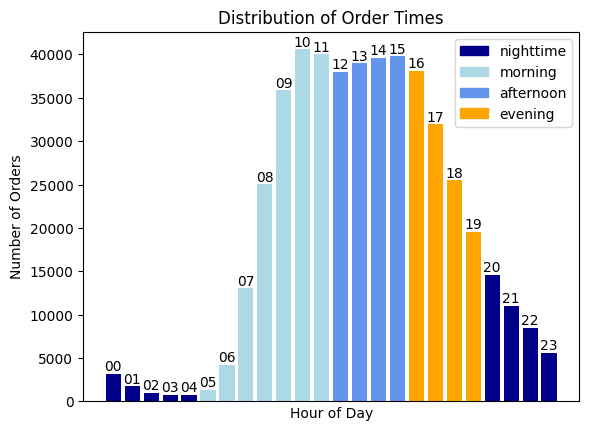

In [16]:
# Make an optically pleasing color scheme
colors=[
    'darkblue','darkblue','darkblue','darkblue','darkblue', # Nighttime 20-04
    'lightblue','lightblue','lightblue','lightblue','lightblue','lightblue','lightblue', # Morning 05-11
    'cornflowerblue','cornflowerblue','cornflowerblue','cornflowerblue', # Afternoon 12-15
    'orange','orange','orange','orange', # Evening 16-19
    'darkblue','darkblue','darkblue','darkblue' # Nighttime 20-04
]
color_labels = {
    'nighttime': 'darkblue',
    'morning': 'lightblue',
    'afternoon': 'cornflowerblue',
    'evening': 'orange'
}

# compute the histogram
hist, bins = np.histogram(i_df['order_hour_of_day'], bins=24)

# create the plot
fig, ax = plt.subplots()
for i in range(len(bins) - 1):
    time_bin = (bins[i], bins[i+1])
    color=colors[i]
    ax.bar(i, hist[i], color=color)
    ax.text(i, hist[i]+0.005, '{:02d}'.format(i), ha='center', va='bottom') # Set the hourly labels to the top of the bars
    
# customize the plot
ax.set_xticks([]) # Hide the ticks at the bottom, since I already have that information at the top
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Orders')
ax.set_title('Distribution of Order Times')

# make a handy legend
handles = [plt.Rectangle((0,0),1,1, color=color_labels[label]) for label in color_labels]
labels = color_labels.keys()
ax.legend(handles, labels)

plt.show()


It appears nighttime is not a popular time to order groceries, I'd speculate that that's because a lot of stores are closed during those times and also 'normal' people sleep during those times. Looks like popular times are late Mornings and Late Afternoon.

### [A3] What day of the week do people shop for groceries?

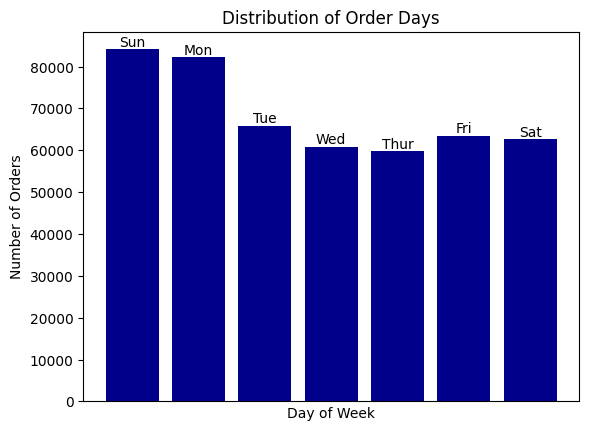

In [17]:
# print(i_df.groupby(['day_of_week_numeral']).size().sort_values(ascending=False))
dow = ["Sun", "Mon", "Tue", "Wed", "Thur", "Fri", "Sat"]

# compute the histogram
hist, bins = np.histogram(i_df['day_of_week_numeral'], bins=7)

# create the plot
fig, ax = plt.subplots()
for i in range(len(bins) - 1):
    ax.bar(i, hist[i], color='darkblue')
    ax.text(i, hist[i]+0.005, dow[i], ha='center', va='bottom') # Set the hourly labels to the top of the bars
    
# customize the plot
ax.set_xticks([]) # Hide the ticks at the bottom, since I already have that information at the top
ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of Orders')
ax.set_title('Distribution of Order Days')

plt.show()

Looks like Sunday and Monday are popular Days. I'd speculate that that's because a lot of people plan their weeks on those days and remember that they need Food that week.

### [A4] How long do people wait until placing another order?

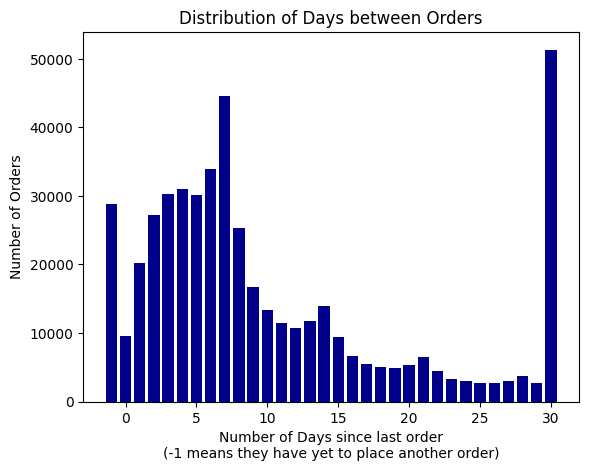

In [18]:
# compute the histogram
hist, bins = np.histogram(i_df['days_since_prior_order'], bins=32)

# create the plot
fig, ax = plt.subplots()
for i in range(len(bins)-1):
    i = i - 1
    ax.bar(i, hist[i+1], color='darkblue')
    
# customize the plot
ax.set_xticks([0, 5, 10, 15, 20, 25, 30])
ax.set_xlabel('Number of Days since last order\n(-1 means they have yet to place another order)', fontsize=10)
ax.set_ylabel('Number of Orders')
ax.set_title('Distribution of Days between Orders')

plt.show()

It looks like the most popular interval is listed as 30 days, maybe the data is supposed to represent '30 or more' days or something like that. In second place is 7 days, which makes sense since a lot of people plan their lives on a weekly basis.

# [B] Medium (must complete all to pass)

### [B1] Is there a difference in `'order_hour_of_day'` distributions on Wednesdays and Saturdays? Plot the histograms for both days and describe the differences that you see.

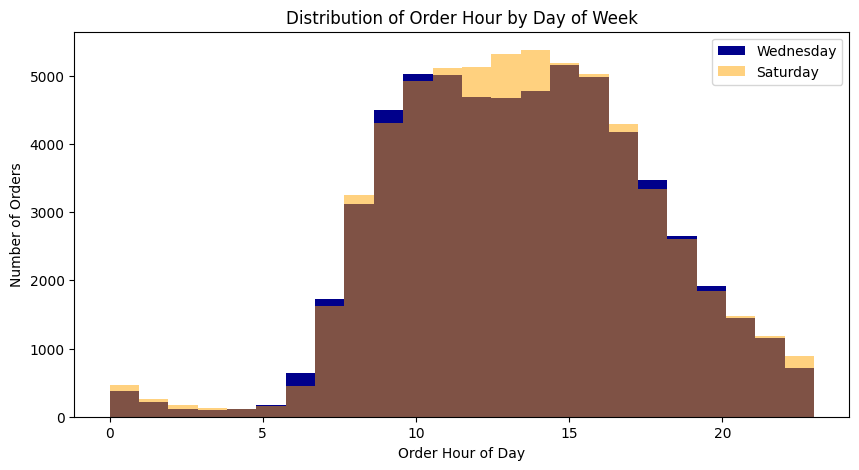

In [19]:
# create two subsets of the data for Wednesdays and Saturdays
wed_df = i_df[i_df['day_of_week'] == 'Wednesday']
sat_df = i_df[i_df['day_of_week'] == 'Saturday']

# create the histogram for Wednesdays
wed_df['order_hour_of_day'].plot(
    kind='hist', 
    bins=24, 
    alpha=1, 
    label='Wednesday', 
    color='darkblue',
    title='Distribution of Order Hour by Day of Week',
    legend=True,
    figsize=[10,5]
)

# create the histogram for Saturdays
sat_df['order_hour_of_day'].plot(
    kind='hist', 
    bins=24, 
    alpha=0.5, 
    label='Saturday', 
    color='orange',
    legend=True
)

plt.xlabel('Order Hour of Day')
plt.ylabel('Number of Orders')

plt.show()


It would appear that slightly more orders are placed in the afternoon on Saturdays than on Wednesdays. That makes sense since most people have Sundays off and work on Wednesdays, so they're free to order Groceries.

### [B2] What's the distribution for the number of orders per customer?

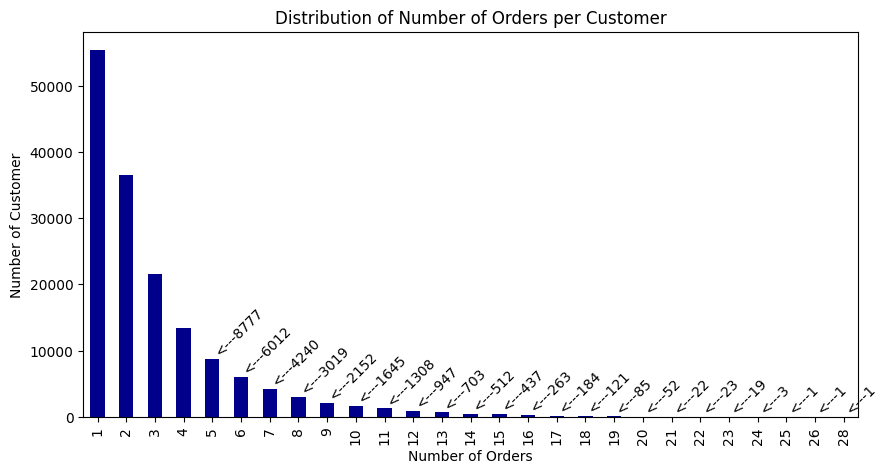

In [20]:
# Count the number of orders per user
user_order_counts = i_df.groupby('user_id')['order_id'].count()

# Count the number of users who have ordered each number of orders
order_counts = user_order_counts.value_counts()

# Sort the order_counts DataFrame by index
order_counts = order_counts.sort_index()

# Create a bar chart with the number of orders on the x-axis and the number of users on the y-axis
order_counts.plot(
    kind='bar',
    xlabel='Number of Orders',
    ylabel='Number of Customer',
    title='Distribution of Number of Orders per Customer',
    color='darkblue',
    figsize=[10, 5]
)

# Add labels to each bar with a value less than 10,000
for i, v in enumerate(order_counts.values):
    if v < 10_000:
        plt.text(i, v, '<---'+str(v), color='black', ha='left', va='bottom', rotation=45)

# Display the plot
plt.show()


It looks like the most common quantity of orders per customer is 1 with what seems to be a moderate logorithmic decline after. Maybe we can add some additional incentives for users to order more. For example, a discount for every 5th or 7th order.

One Customer seems to have ordered 28 times, though. 

### [B3] What are the top 20 popular products (display their id and name)?

In [21]:
# Isolate product ids (and frequencies) of the top 20 most frequently Ordered Products from the order_products df
order_freq_full = o_df.groupby('product_id')['order_id'].count().sort_values(ascending=False).reset_index()
order_freq_full = order_freq_full.rename(columns={'order_id': 'times_ordered'})
order_freq = order_freq_full.head(20)

# Check Data
# print(order_freq)

In [22]:
# Map product_id to id in p_df and add the name column
order_freq = order_freq.merge(p_df[['product_id', 'name']], on='product_id')

# Display order_freq
print(order_freq[['product_id', 'name', 'times_ordered']])

   product_id                      name  times_ordered
0       24852                    banana          66046
1       13176    bag of organic bananas          53295
2       21137      organic strawberries          37035
3       21903      organic baby spinach          33970
4       47209      organic hass avocado          29772
5       47766           organic avocado          24689
6       47626               large lemon          21495
7       16797              strawberries          20017
8       26209                     limes          19689
9       27845        organic whole milk          19600
10      27966       organic raspberries          19194
11      22935      organic yellow onion          15897
12      24964            organic garlic          15290
13      45007          organic zucchini          14584
14      39275       organic blueberries          13879
15      49683            cucumber kirby          13674
16      28204        organic fuji apple          12544
17       5

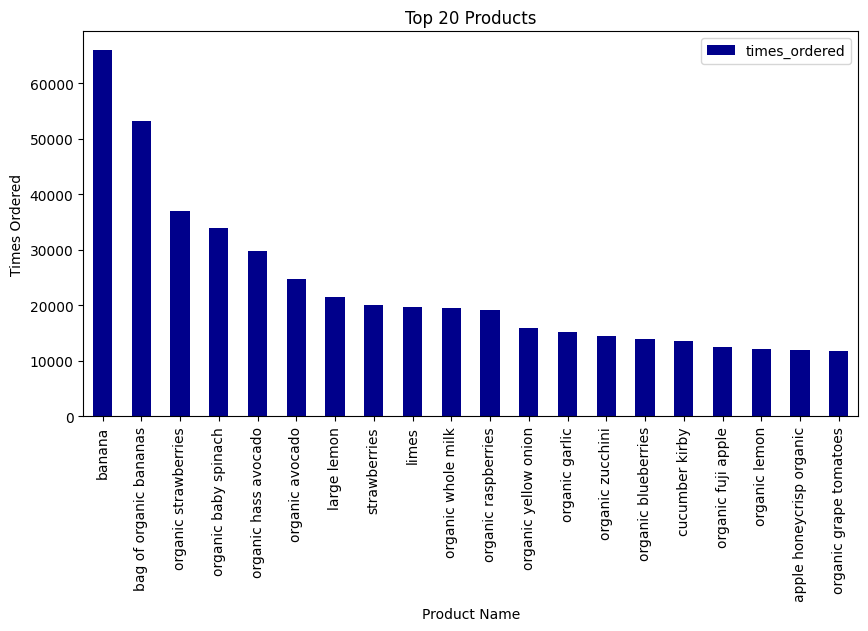

In [23]:
# Make a Bar Chart
order_freq.plot(
    kind='bar',
    x='name',
    y='times_ordered',
    xlabel='Product Name',
    ylabel='Times Ordered',
    color='darkblue',
    title='Top 20 Products',
    figsize=[10, 5],
    rot=90
)

# Display the plot
plt.show()

Looks like Bananas are the most popular. If I remember correctly, they're added to the cart individually, so it makes sense that people buy several at a time. The rest appears to be more produce, which also makes sense since they don't last too long, so they need to be bought again frequently.

# [C] Hard (must complete at least two to pass)

### [C1] How many items do people typically buy in one order? What does the distribution look like?

In [24]:
# Find max cart_id per order
items_per_order = o_df.groupby('order_id')['cart_item_id'].max()

# print(items_per_order.sample(10))


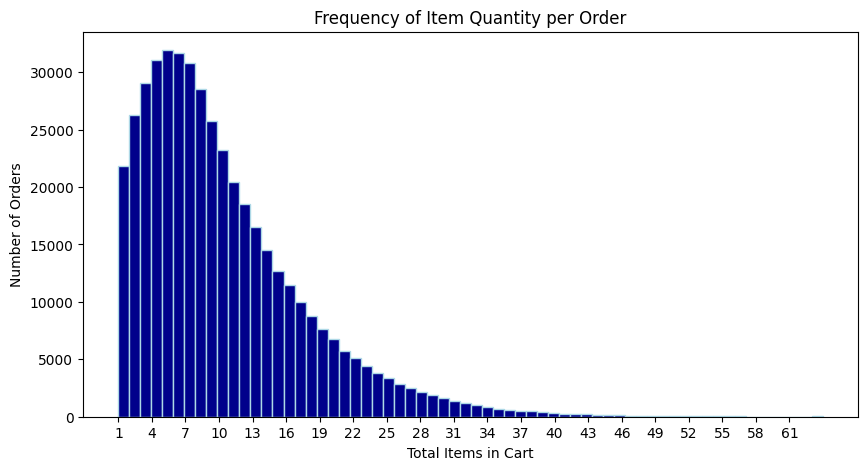

In [25]:
items_per_order.plot(
    kind='hist',
    bins=64,
    xticks=range(1, 64, 3),
    edgecolor='lightblue',
    color='darkblue',
    title='Frequency of Item Quantity per Order',
    figsize=[10, 5]
)

plt.xlabel('Total Items in Cart')
plt.ylabel('Number of Orders')

plt.show()

It seems most order have between 2 and 9 items.

### [C2] What are the top 20 items that are reordered most frequently (display their names and product IDs)?

In [26]:
# Find 20 most reordered items grouped by product_ids
most_reordered = o_df.groupby('product_id')['reordered'].sum().sort_values(ascending=False).head(20).reset_index()

# print(most_reordered)

# rename column
most_reordered = most_reordered.rename(columns={'reordered': 'times_reordered'})


In [27]:
# Map product_id to id in p_df and add the name column
most_reordered.loc[:, 'name'] = most_reordered['product_id'].apply(lambda x: p_df.set_index('product_id').loc[x, 'name'])

# print(most_reordered)

In [28]:
# Map product_id to id in p_df and add the name column
most_reordered.loc[:, 'times_ordered'] = most_reordered['product_id'].apply(lambda x: order_freq_full.set_index('product_id').loc[x, 'times_ordered'])

print(most_reordered[['product_id', 'name', 'times_ordered', 'times_reordered']])

   product_id                      name  times_ordered  times_reordered
0       24852                    banana          66046            55761
1       13176    bag of organic bananas          53295            44448
2       21137      organic strawberries          37035            28637
3       21903      organic baby spinach          33970            26232
4       47209      organic hass avocado          29772            23628
5       47766           organic avocado          24689            18743
6       27845        organic whole milk          19600            16251
7       47626               large lemon          21495            15044
8       27966       organic raspberries          19194            14747
9       16797              strawberries          20017            13944
10      26209                     limes          19689            13326
11      22935      organic yellow onion          15897            11144
12      24964            organic garlic          15290          

To no one's suprise, it looks like the most reordered items are also the the most ordered from earlier. This isn't very useful, but looking at how many were not reordered might yeild interesting results about product satisfaction...

### [C3] For each product, what proportion of its orders are reorders?

In [29]:
reo_perc = o_df.groupby('product_id')['reordered'].sum().reset_index().rename(columns={'reordered': 'times_reordered'})
reo_perc = reo_perc.merge(order_freq_full[['product_id', 'times_ordered']], on='product_id')

reo_perc['reorder_percentage'] = reo_perc['times_reordered'] / reo_perc['times_ordered']

reo_perc = reo_perc.sort_values(by='times_ordered', ascending=False)

# print(reo_perc.head(20))

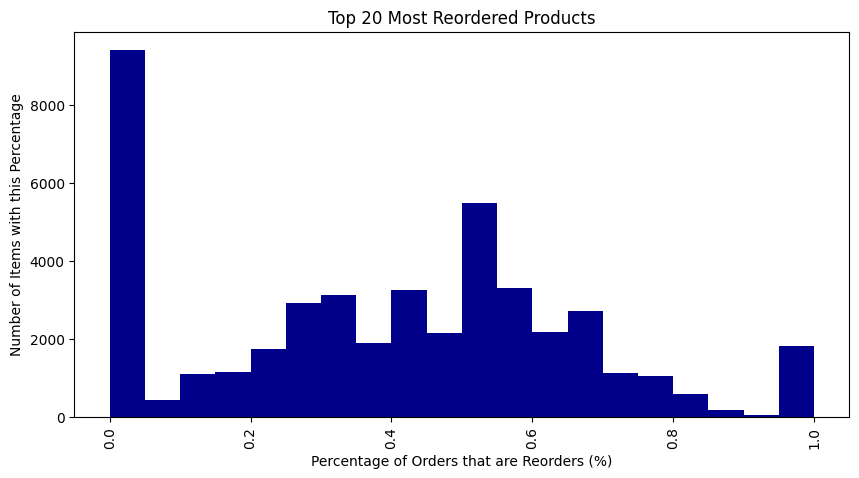

In [30]:
# Make a Bar Chart
reo_perc.plot(
    kind='hist',
    bins=20,
    y='reorder_percentage',
    color='darkblue',
    title='Top 20 Most Reordered Products',
    figsize=[10, 5],
    rot=90,
    legend=False
)

plt.xlabel('Percentage of Orders that are Reorders (%)')
plt.ylabel('Number of Items with this Percentage')

# Display the plot
plt.show()

### [C4] For each customer, what proportion of their products ordered are reorders?

In [31]:
users_orders = i_df.merge(o_df, on='order_id')
user_reo_ratio = users_orders.groupby('user_id').agg({'user_id': 'count', 'reordered': ['sum', 'count']})

user_reo_ratio.columns = ['_'.join(col).rstrip('_') for col in user_reo_ratio.columns.values]
user_reo_ratio['reorder_ratio'] = user_reo_ratio['reordered_sum'] / user_reo_ratio['reordered_count']

# print(user_reo_ratio.sample(20))

# # Display the results
# print(grouped_df.head())


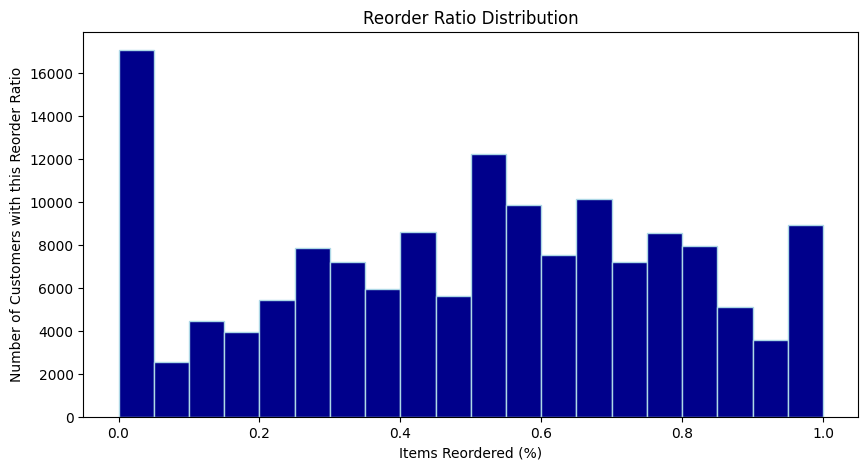

In [32]:
user_reo_ratio['reorder_ratio'].plot(
    kind='hist',
    bins=20,
    title='Reorder Ratio Distribution',
    edgecolor='lightblue',
    color='darkblue',
    figsize=[10, 5]
)

plt.xlabel('Items Reordered (%)')
plt.ylabel('Number of Customers with this Reorder Ratio')

plt.show()

### [C5] What are the top 20 items that people put in their carts first? 

In [33]:
# Filter out all items that aren't first in the cart
first_picks = o_df[o_df['cart_item_id'] == 1].reset_index()

# print(first_picks.sample(20))
# first_picks.info()

In [34]:
# Count the number of times each item ocurrs and just get Top 20
first_pick_counts = first_picks.groupby('product_id')['order_id'].count().sort_values(ascending=False).reset_index()
first_pick_counts = first_pick_counts.rename(columns={'order_id': 'times_first'}).head(20)

# print(first_pick_counts)

In [35]:
# Add the Product Names
first_pick_counts['name'] = first_pick_counts['product_id'].apply(lambda x: p_df.set_index('product_id').loc[x, 'name'])

print(first_pick_counts[['name', 'times_first']])

                           name  times_first
0                        banana        15562
1        bag of organic bananas        11026
2            organic whole milk         4363
3          organic strawberries         3946
4          organic hass avocado         3390
5          organic baby spinach         3336
6               organic avocado         3044
7                  spring water         2336
8                  strawberries         2308
9           organic raspberries         2024
10   sparkling water grapefruit         1914
11          organic half & half         1797
12                  large lemon         1737
13                         soda         1733
14     organic reduced fat milk         1397
15                        limes         1370
16                hass avocados         1340
17  organic reduced fat 2% milk         1310
18                  half & half         1309
19         organic yellow onion         1246


It looks like the number of times an item is put into a cart first is proportional to Total orders, except further down the list, it look like people remember they need dairy products like *milk* and *half & half* first.